# Sample solutions

In [1]:
!pip install memory-profiler --user
!pip install yellowbrick --user

In [2]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

In /home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pioters/anaconda3/lib/python3.6/site-packages/m

In [3]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

/home/pioters/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/pioters/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/pioters/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/pioters/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/pioters/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDepreca

# Problem 1

1. Load the data

In [4]:
X = np.load("../data/data/p2_unsupervised/X.npy")
# y = np.load("data/p1/y.npy")

In [6]:
# 511 cells, 45768 genes
print(X.shape)

(2169, 45768)


In [7]:
# Largest entry of first column
np.max(X[:,0])

61.77721743231262

2. Log transform

In [7]:
# Log 
X_log = np.log2(X + 1)

In [8]:
# Largest entry of first column
print(np.max(X_log[:,0]))

5.972169178513185


3. Full PCA, raw vs transformed data

In [9]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 5531.57 MiB, increment: 3853.48 MiB
41.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print("First component log:", pca_log.explained_variance_ratio_[0])

First component raw: 0.42638226170185967
First component log: 0.15494937162426226


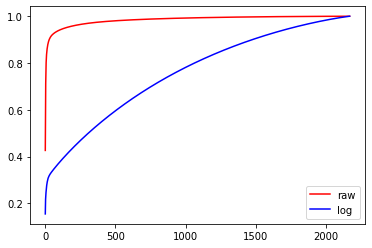

In [15]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [16]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 12
Log: 1253


4. Plotting without visualization techniques

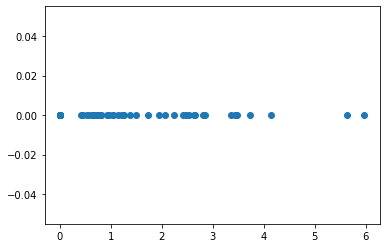

In [17]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

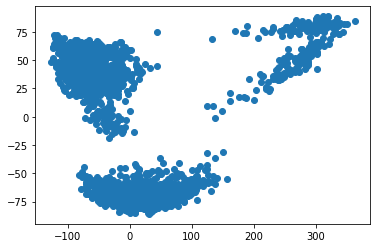

In [11]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])
plt.savefig("pca_log.png")

In [19]:
plt.savefig("pca_log.png")

<Figure size 432x288 with 0 Axes>

6. MDS (sklearn version is nonlinear)

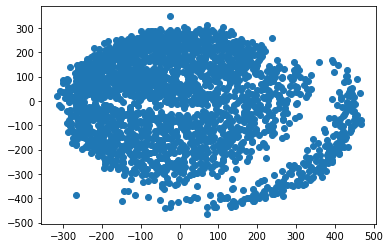

In [21]:
# We still see 3 distinct clusters.
mds=MDS(n_components=2).fit_transform(X_log)
plt.scatter(mds[:,0],mds[:,1])

7. T-SNE

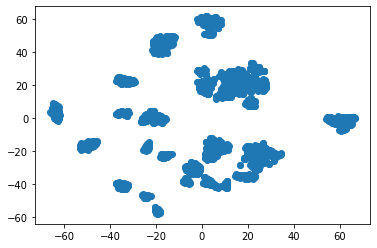

In [22]:
# Emergence of at least 5 clusters. 
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

8. K-Means

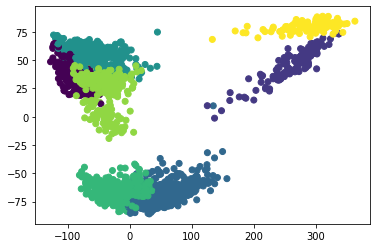

In [27]:
# 5 clusters: PCA plot
kmeans = KMeans(7, tol=1e-6)
kmeans.fit(z[:,0:50])
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)
plt.savefig("pca_kmeans_diffclusters.png")

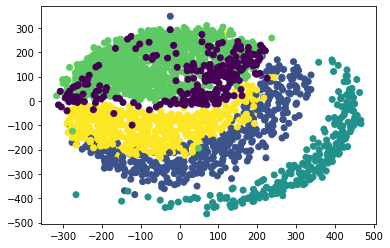

In [24]:
# 5 clusters: MDA with K means plot
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

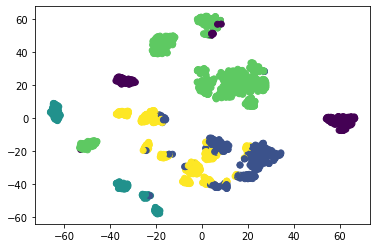

In [25]:
# T-SNE plot
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 33374018.851209417
Num clusters 3 Inertia: 24842205.384147115
Num clusters 4 Inertia: 22601387.38893723
Num clusters 5 Inertia: 20826486.207529794
Num clusters 6 Inertia: 19434348.369125277
Num clusters 7 Inertia: 18494320.134606835
Num clusters 8 Inertia: 17089441.158161525
Num clusters 9 Inertia: 16560398.545052666


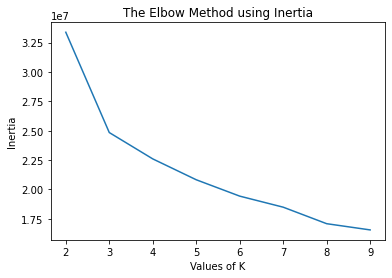

In [14]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.savefig("elbow-results.png")

In [5]:
# 5 clusters: PCA plot
kmeans = KMeans(3, tol=1e-6)
kmeans.fit(X)
labels=kmeans.labels_
#plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)
#plt.savefig("pca_kmeans_diffclusters.png")

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

>0.0000 0.993 (0.006)
>0.0001 0.993 (0.006)
>0.0010 0.993 (0.006)
>0.0100 0.992 (0.006)
>0.1000 0.992 (0.006)
>1.0000 0.992 (0.006)


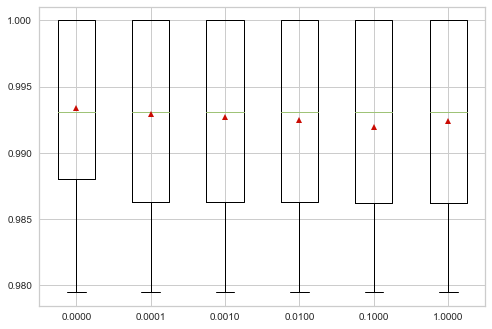

In [13]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
#     X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return X_train, y_train
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.0000 nan (nan)
>0.0001 nan (nan)
>0.0010 nan (nan)
>0.0100 nan (nan)
>0.1000 nan (nan)
>1.0000 nan (nan)


/home/pioters/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/pioters/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


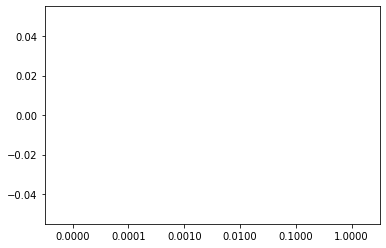

In [7]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
#     X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return X_train, y_train
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='liblinear', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='liblinear', penalty='l1', C=p)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
#     X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return X_train, y_train
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='saga',l1_ratio=0.5, penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='saga',l1_ratio=0.5, penalty='elasticnet', C=p)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Computing regularization path ...
This took 60.991s


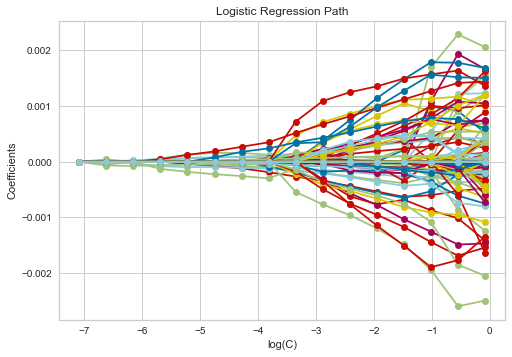

<Figure size 576x396 with 0 Axes>

In [20]:
from time import time
from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c
print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)
X1=X_train
y1=y_train
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X1, y1)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()
plt.savefig("l1-regu.png")

In [ ]:
from time import time
from time import time
from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c
print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='elasticnet', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),l1_ratio=0.5,
                                      warm_start=True,
                                      intercept_scaling=10000.)
X1=X_train
y1=y_train
cs = l1_min_c(X1, y1, loss='log') * np.logspace(0, 7, 16)

coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X1, y1)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()
plt.savefig("elastic-regu.png")


Computing regularization path ...


In [ ]:
%%timeit -n 1 -r 1
%%memit -r 1


10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [20]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 98 with stress 6342.534572033932
breaking at iteration 166 with stress 6080.44123860059
breaking at iteration 95 with stress 6342.512244781481
breaking at iteration 105 with stress 6079.000721967379


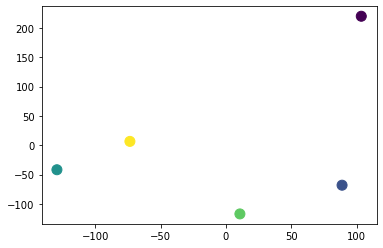

In [21]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

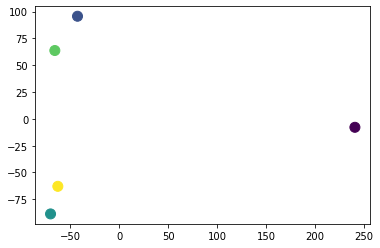

In [22]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

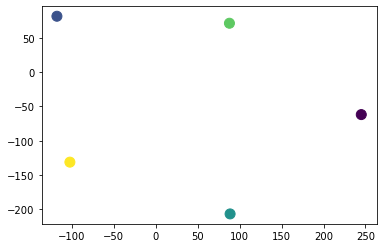

In [26]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

12. PCA/T-SNE on Raw Data

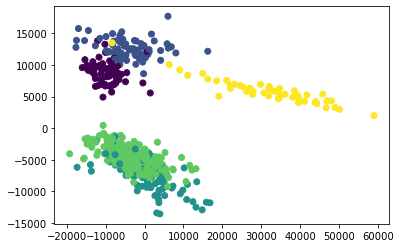

In [32]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

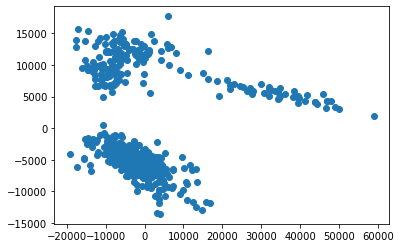

In [33]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

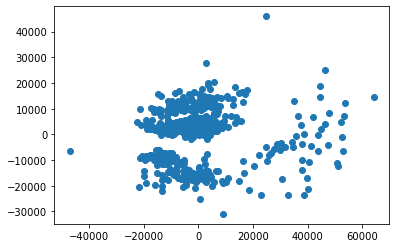

In [31]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

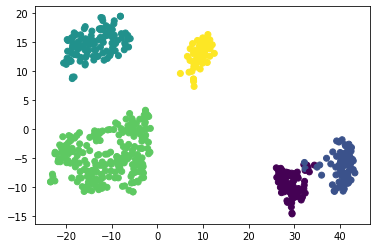

In [28]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

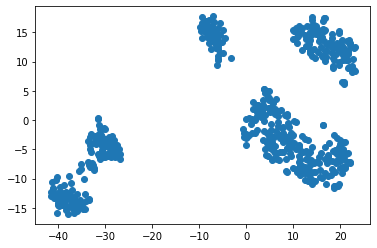

In [34]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])